In [25]:
# Importing Required Libraries
import torch  # PyTorch for deep learning
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional interface for neural networks
import torchvision  # PyTorch's computer vision library
import torchvision.transforms as transforms  # Transformations for image preprocessing
from imageio import imread  # Library to read images
import numpy as np  # Numerical operations on arrays
import matplotlib.pyplot as plt  # Visualization

# Importing Required Libraries
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

# Load Pretrained VGG19 Model

In [26]:
model = torchvision.models.vgg19(pretrained=True)  # Load the VGG19 model with pretrained weights

# Freeze all parameters
for param in model.parameters():  # Iterate over all the parameters in the model
    param.requires_grad = False  # Disable gradient computation for all parameters

# Switch to evaluation mode
model.eval()  # Set the model to evaluation mode (affects layers like dropout, batchnorm)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Set Up Device for GPU Usage

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, else CPU
model.to(device)  # Move the model to the chosen device

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Load content and style images

In [38]:
content_image = imread('input2.jpg')  # Load the content image from a file
style_image = imread('style.jpg')  # Load the style image from a URL
target_image = np.random.randint(0, 255, content_image.shape, dtype=np.uint8)  # Create a target image with random values, same shape as the content image


# Preprocess Images

In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Resize(256),  # Resize image to 256x256 pixels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with mean and std deviation
])

content_image = transform(content_image).unsqueeze(0).to(device)  # Apply transformations and move to device
style_image = transform(style_image).unsqueeze(0).to(device)  # Apply transformations and move to device
target_image = transform(target_image).unsqueeze(0).to(device)  # Apply transformations and move to device


# Display Initial Images

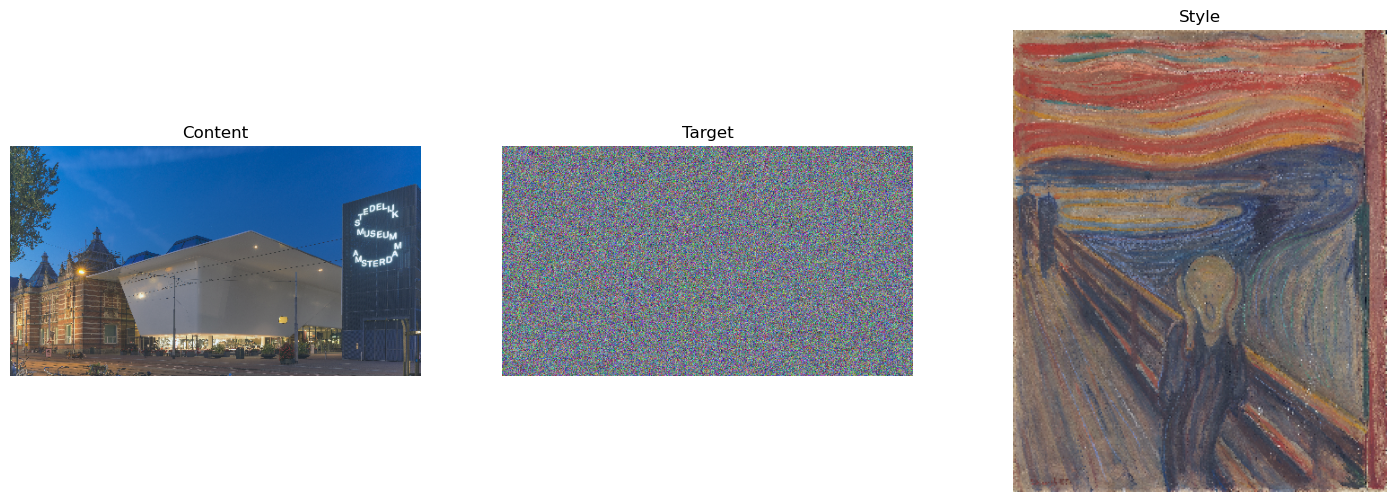

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure with 3 subplots

for idx, img in enumerate([content_image, target_image, style_image]):  # Loop over images
    img = img.cpu().squeeze().numpy().transpose(1, 2, 0)  # Move to CPU, remove batch dimension, and transpose
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    axes[idx].imshow(img)  # Display the image
    axes[idx].set_title(['Content', 'Target', 'Style'][idx])  # Set the title
    axes[idx].axis('off')  # Remove axes

plt.show()  # Show the plot


# Define Feature Extraction and Gram Matrix Functions

In [19]:
def extract_features(image, net):
    features = []  # List to store feature maps
    layer_names = []  # List to store layer names
    conv_layer_idx = 0  # Counter for convolutional layers

    for layer in range(len(net.features)):  # Loop over all layers in the feature extractor
        image = net.features[layer](image)  # Apply the layer to the image
        if isinstance(net.features[layer], nn.Conv2d):  # Check if the layer is a convolutional layer
            features.append(image)  # Store the feature map
            layer_names.append(f'ConvLayer_{conv_layer_idx}')  # Store the layer name
            conv_layer_idx += 1  # Increment the counter

    return features, layer_names  # Return the feature maps and layer names

# Function to compute the Gram matrix of a tensor
def compute_gram_matrix(tensor):
    b, c, h, w = tensor.size()  # Get the batch size, channels, height, and width
    tensor = tensor.view(c, h * w)  # Reshape the tensor to (channels, height * width)
    gram = torch.mm(tensor, tensor.t())  # Compute the Gram matrix
    return gram.div(c * h * w)  # Normalize by the number of elements and return


# Extract and Display Feature Maps for Content Image

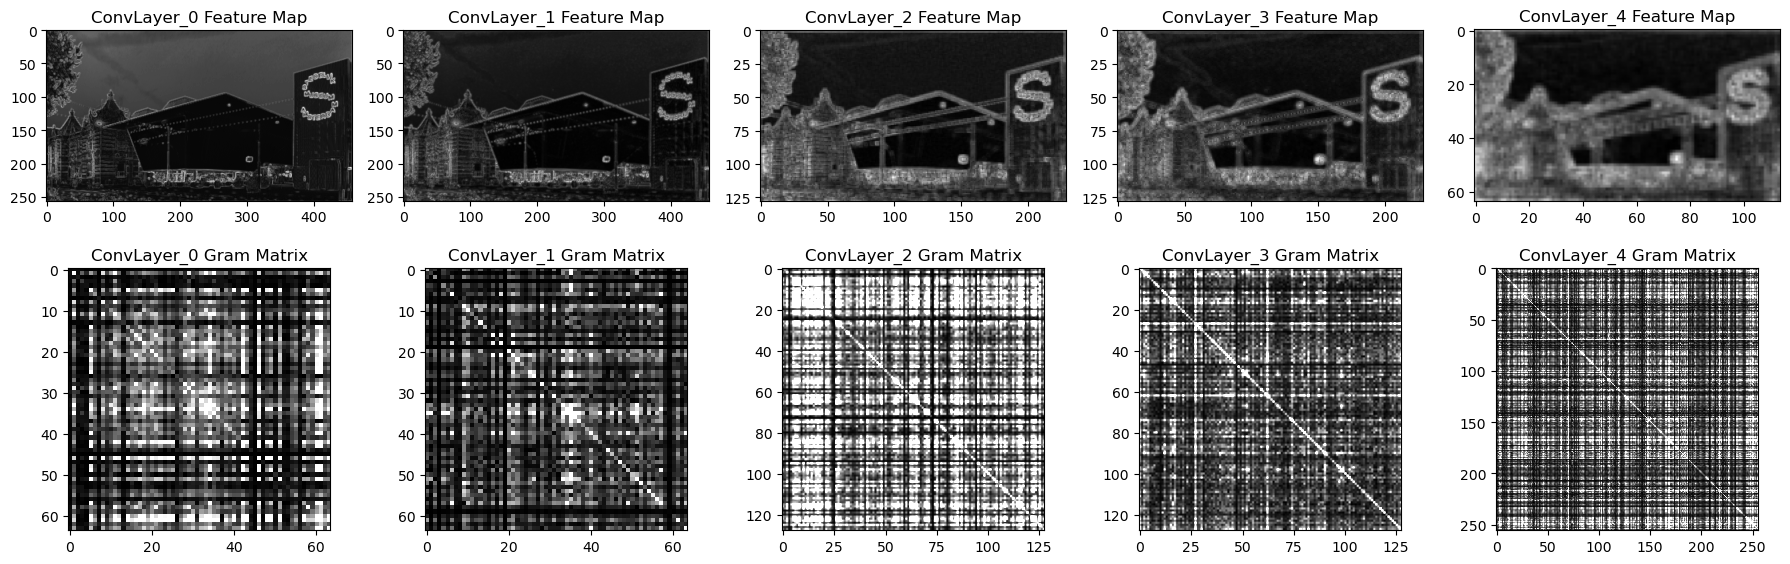

In [31]:
content_features, content_layers = extract_features(content_image, model)  # Extract feature maps and layer names

fig, axs = plt.subplots(2, 5, figsize=(18, 6))  # Create a figure with 2x5 subplots

for i in range(5):  # Loop over the first 5 layers
    feature_map = content_features[i].cpu().squeeze().numpy().mean(axis=0)  # Compute the mean of the feature map across channels
    feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())  # Normalize to [0, 1]
    axs[0, i].imshow(feature_map, cmap='gray')  # Display the feature map
    axs[0, i].set_title(f'{content_layers[i]} Feature Map')  # Set the title

    gram_matrix = compute_gram_matrix(content_features[i]).cpu().numpy()  # Compute the Gram matrix
    gram_matrix = (gram_matrix - gram_matrix.min()) / (gram_matrix.max() - gram_matrix.min())  # Normalize to [0, 1]
    axs[1, i].imshow(gram_matrix, cmap='gray', vmax=0.1)  # Display the Gram matrix
    axs[1, i].set_title(f'{content_layers[i]} Gram Matrix')  # Set the title

plt.tight_layout()  # Adjust the layout
plt.show()  # Show the plot


# Extract and Display Feature Maps for Style Image

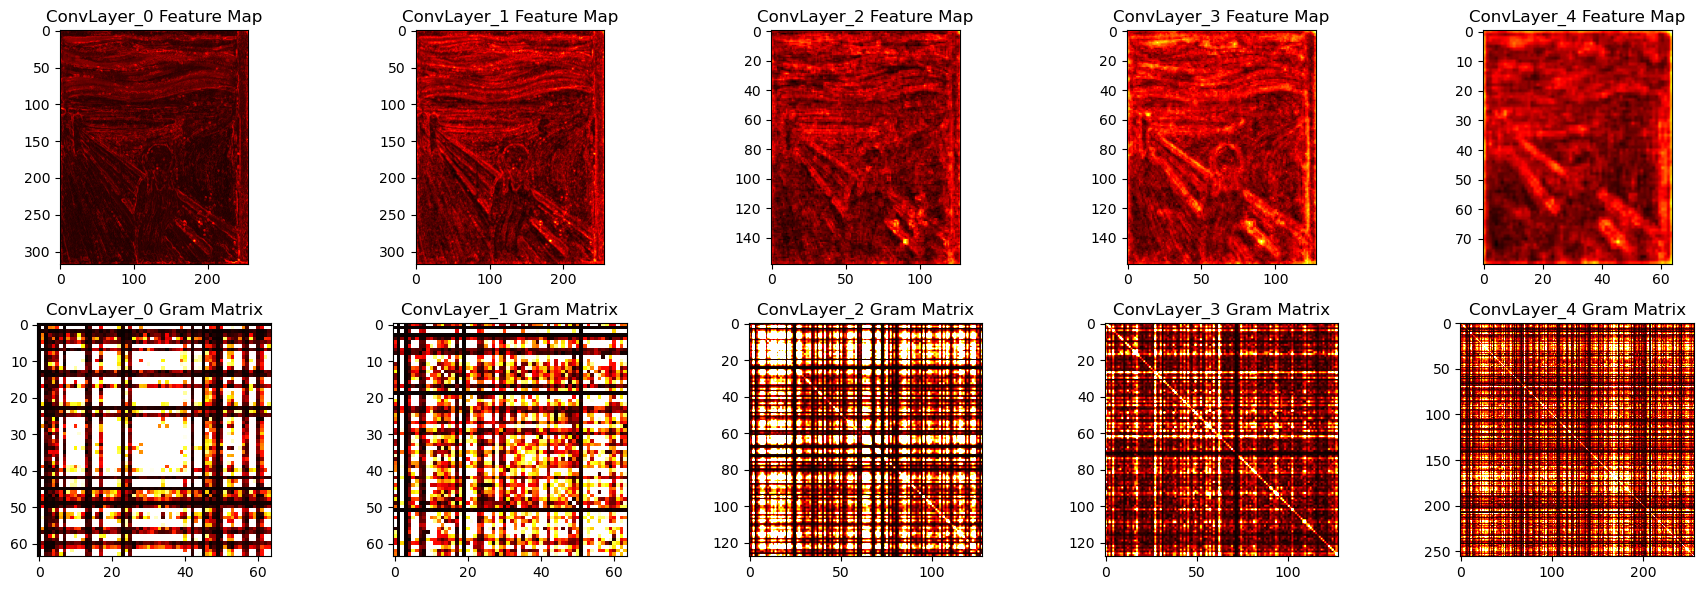

In [21]:
style_features, style_layers = extract_features(style_image, model)  # Extract feature maps and layer names

fig, axs = plt.subplots(2, 5, figsize=(18, 6))  # Create a figure with 2x5 subplots

for i in range(5):  # Loop over the first 5 layers
    feature_map = style_features[i].cpu().squeeze().numpy().mean(axis=0)  # Compute the mean of the feature map across channels
    feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())  # Normalize to [0, 1]
    axs[0, i].imshow(feature_map, cmap='hot')  # Display the feature map
    axs[0, i].set_title(f'{style_layers[i]} Feature Map')  # Set the title

    gram_matrix = compute_gram_matrix(style_features[i]).cpu().numpy()  # Compute the Gram matrix
    gram_matrix = (gram_matrix - gram_matrix.min()) / (gram_matrix.max() - gram_matrix.min())  # Normalize to [0, 1]
    axs[1, i].imshow(gram_matrix, cmap='hot', vmax=0.1)  # Display the Gram matrix
    axs[1, i].set_title(f'{style_layers[i]} Gram Matrix')  # Set the title

plt.tight_layout()  # Adjust the layout
plt.show()  # Show the plot


# Perform Style Transfer

In [32]:
# Define content and style layers for feature extraction
content_layers = ['ConvLayer_1', 'ConvLayer_4']  # Layers to use for content representation
style_layers = ['ConvLayer_1', 'ConvLayer_2', 'ConvLayer_3', 'ConvLayer_4', 'ConvLayer_5']  # Layers to use for style representation
style_weights = [1, 0.5, 0.5, 0.2, 0.1]  # Weights for each style layer

# Prepare the target image for optimization
target = target_image.clone().requires_grad_(True).to(device)  # Clone the target image, set requires_grad to True, and move to device
style_scale = 1e6  # Scaling factor for style loss
epochs = 1500  # Number of optimization steps
optimizer = torch.optim.RMSprop([target], lr=0.005)  # RMSprop optimizer with learning rate of 0.005

# Optimization loop
for epoch in range(epochs):  # Loop over epochs
    target_features, target_layers = extract_features(target, model)  # Extract features of the target image
    style_loss, content_loss = 0, 0  # Initialize style and content loss

    for idx, layer in enumerate(target_layers):  # Loop over target layers
        if layer in content_layers:  # If the layer is used for content representation
            content_loss += F.mse_loss(target_features[idx], content_features[idx])  # Compute content loss

        if layer in style_layers:  # If the layer is used for style representation
            gram_target = compute_gram_matrix(target_features[idx])  # Compute Gram matrix of target features
            gram_style = compute_gram_matrix(style_features[idx])  # Compute Gram matrix of style features
            style_loss += F.mse_loss(gram_target, gram_style) * style_weights[style_layers.index(layer)]  # Compute style loss and weight it

    total_loss = style_scale * style_loss + content_loss  # Compute total loss
    optimizer.zero_grad()  # Zero the gradients
    total_loss.backward()  # Backpropagate the loss
    optimizer.step()  # Update the target image


# Display Final Images

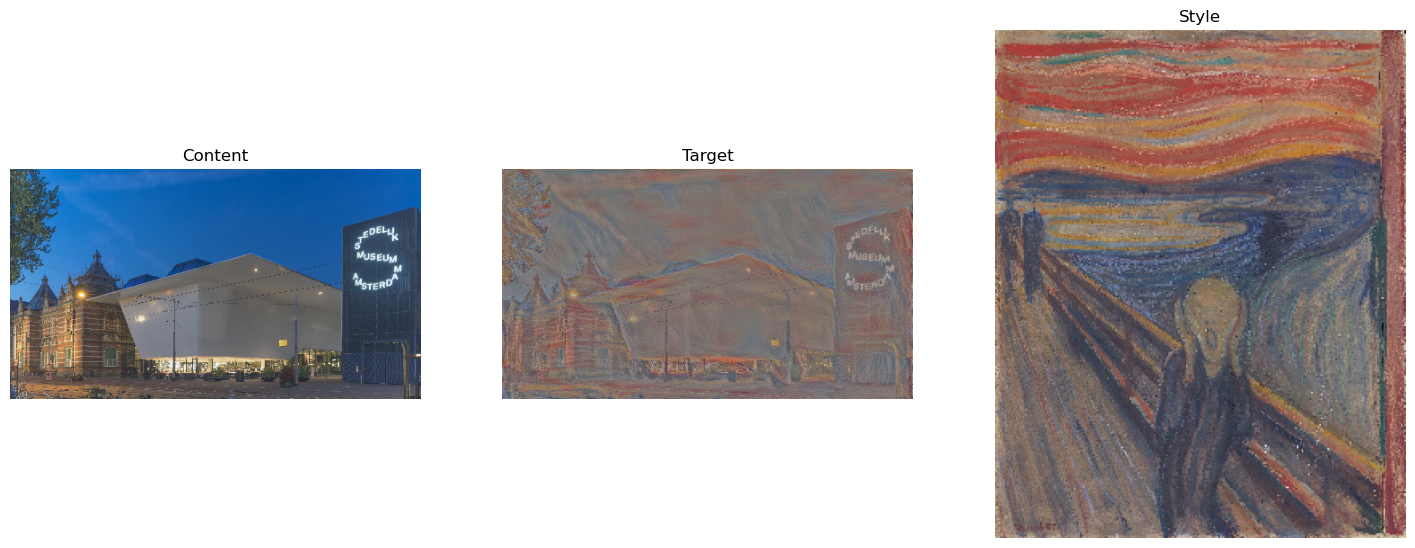

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 11))  # Create a figure with 3 subplots

for idx, img in enumerate([content_image, target, style_image]):  # Loop over images
    img = img.cpu().detach().squeeze().numpy().transpose(1, 2, 0)  # Move to CPU, remove batch dimension, and transpose
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    axes[idx].imshow(img)  # Display the image
    axes[idx].set_title(['Content', 'Target', 'Style'][idx])  # Set the title
    axes[idx].axis('off')  # Remove axes

plt.show()  # Show the plot